In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [21]:
import seaborn as sns
import torch
from lightning.pytorch import seed_everything
from matplotlib import pyplot as plt

from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.datasets import HelocDataset
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.metrics import CFMetrics

In [22]:
seed_everything(42, workers=True)

Seed set to 42


42

In [23]:
# dataset = MnistDataset("../data/mnist.csv")
# dataset = LawDataset("../data/law.csv")
dataset = HelocDataset("../data/heloc.csv")
# dataset = AuditDataset("../data/audit.csv")
# dataset = MoonsDataset("../data/moons.csv")

In [24]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=5000,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="disc_model.pt",
# )
disc_model.load("heloc_disc_model.pt")

/home/lukasz/genwro/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(to

In [25]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [26]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.7189873417721518


In [27]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [28]:
# dataset = MoonsDataset("../data/moons.csv")
# dataset = MnistDataset("../data/mnist.csv")
# train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
# test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=1024, shuffle=True),
#     dataset.test_dataloader(batch_size=1024, shuffle=False),
#     epochs=1000
# )

gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

# gen_model.fit(
#     train_dataloader,
#     train_dataloader,
#     learning_rate=1e-3,
#     patience=100,
#     num_epochs=500,
#     checkpoint_path="heloc_flow.pth"
# )
gen_model.load("heloc_flow.pth")

/home/lukasz/genwro/counterfactuals/counterfactuals/generative_models/maf/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [29]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [30]:
dataset.features

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'MSinceMostRecentDelq',
 'MaxDelq2PublicRecLast12M',
 'MaxDelqEver',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'PercentTradesWBalance',
 'RiskPerformance']

In [31]:
dataset.features[4]
dataset.features[17]
dataset.features[18]
dataset.features[19]
dataset.features[20]

'NumInstallTradesWBalance'

In [32]:
dataset.actionable_features = [4, 17, 18, 19, 20]
dataset.not_actionable_features = [
    0,
    1,
    2,
    3,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    21,
    22,
]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

loss: 513.2159, dist: 2.1219, max_inner: 1.4089, loss_disc: 0.0085, delta_loss: 287.5548: 100%|██████████| 3000/3000 [00:51<00:00, 58.48it/s]  


Correct: 903/1034
6


{'coverage': 1.0,
 'validity': 0.9825918762088974,
 'actionability': 0.0,
 'sparsity': 0.21739130434782608,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 1.1619875882720545,
 'proximity_continuous_manhattan': 2.1255893987462207,
 'proximity_continuous_euclidean': 1.1619875882720545,
 'proximity_continuous_mad': 38.83581497159697,
 'proximity_l2_jaccard': 1.1619875882720545,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.8762088974854932,
 'log_density_cf': -32.04062,
 'log_density_test': -35.004887,
 'lof_scores_cf': 2.4171183,
 'lof_scores_test': 1.0901632,
 'isolation_forest_scores_cf': -0.027195892451528505,
 'isolation_forest_scores_test': 0.05175606822239104}

In [33]:
import numpy as np

In [34]:
np.save("d_reg.npy", D.detach().numpy())

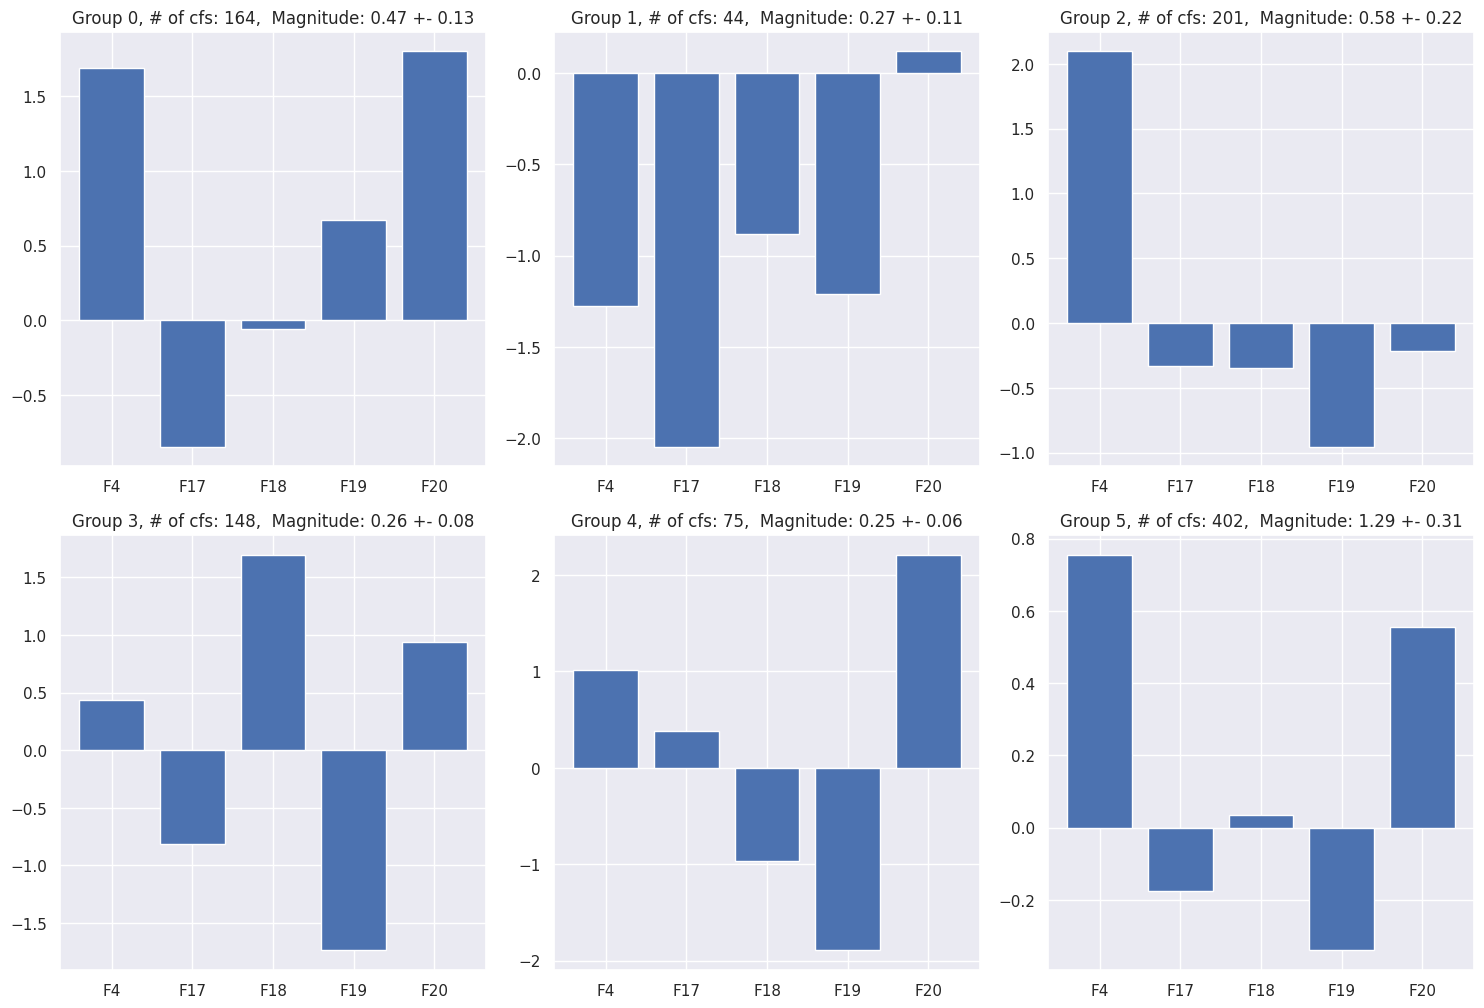

In [35]:
plt.figure(figsize=(15, 15))
sns.set(style="darkgrid")

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        [f"F{feat_num}" for feat_num in dataset.actionable_features],
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"Group {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )
    plt.tight_layout()

In [36]:
for feat in dataset.actionable_features:
    print(dataset.features[feat])

NumSatisfactoryTrades
NetFractionRevolvingBurden
NetFractionInstallBurden
NumRevolvingTradesWBalance
NumInstallTradesWBalance


# HELOC Analysis
The study identifies several features as actionable, which are vulnerable to direct influence by borrowers through specific financial behaviors. These features include:

- F4: Number of Satisfactory Trades – Indicates successfully completed credit engagements.
- F17: Net Fraction of Revolving Burden – The ratio of revolving credit used to the total credit limit.
- F18: Net Fraction of Installment Burden – The portion of installment debt relative to the original loan amount.
- F19: Number of Revolving Trades with Balance – Counts ongoing revolving credit transactions.
- F20: Number of Installment Trades with Balance – Counts ongoing installment credit transactions.

These features were selected for their potential for rapid modification, in contrast to features that require extended periods to influence, allowing for targeted adjustments in financial behavior.

# Analysis by Group
# Group 0
For individuals in this category, it is advisable to methodically increase the **Number of Satisfactory Trades**, the **Number of Installment Trades with Balance**, and the **Number of Revolving Trades with Balance**. Simultaneously, they should aim to decrease the **Net Fraction of Revolving Burden**. This group likely possesses a limited credit history, which necessitates deliberate actions to cultivate a more substantial credit profile and enhance their perceived reliability.

# Group 1
For this group, the strategy involves reducing all features except the **Number of Installment Trades with Balance**. These individuals likely engage in frequent credit card and installment transactions, which classifies them as high-risk. Therefore, the approach focuses on minimizing their overall credit exposure, aiming to balance their financial profile and enhance their creditworthiness.

# Group 2
Members of the second largest group should focus on gradually increasing the **Number of Satisfactory Trades** while reducing all other factors. Notably, this is the only group advised against increasing the **Number of Installment Trades with Balance**, a feature that significantly impacts plausibility within the population. Current plausibility seems to be sufficient.

# Group 3
Representing a significant segment, these individuals are advised to decrease the **Number of Revolving Trades with Balance** and the **Net Fraction of Revolving Burden**. Conversely, an increase in the **Net Fraction of Installment Burden** and the **Number of Installment Trades with Balance** is recommended. At first glance, this strategy might seem counterintuitive, as it involves increasing features that are theoretically negative. However, such increases can enhance the plausibility of the profiles, making them more realistic and potentially improving their overall creditworthiness.

# Group 4
As usual, explanations in this gropup include increasing the **Number of Satisfactory Trades** and the **Number of Installment Trades with Balance** while reducing the **Number of Revolving and Installment Trades with Balance** along with adjustments to the **Net Fraction of Installment Burden**. These targeted actions aim to enhance the group's credit profile by demonstrating responsible financial management and reducing overall debt load.

# Group 5
In the largest group, the explanation suggests elevating the **Number of Satisfactory Trades** and the **Number of Installment Trades with Balance**, despite its potential to lower the likelihood of credit approval. Additionally, the explanation recommends reductions in the **Net Fraction of Revolving Burden** and the **Number of Revolving Trades with Balance**. This approach is designed to enhance the group’s credit profile while maintaining a high level of plausibility.

# Summary
Across nearly all groups, enhancing the **Number of Satisfactory Trades** emerges as a critical factor in credit approval decisions. While most groups are advised to increase the **Number of Installment Trades with Balance**, a feature that might seem counterintuitive, it is considered to significantly influence model plausibility. Additionally, reducing the **Net Fraction of Revolving Burden** is almost always beneficial, improving credit profiles across various scenarios. 